In [44]:
#Handle general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution
import sys

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.cm as cm

structuring_code_path = "../structuring_code/"
sum_path = "../joule_declass_sum/"
raw_path = "../joule_declass_raw/"
joule_cell_id_path =  "../Joule_cell_id.csv"
saved_data_path = "../saved_fitting_results/"
sys.path.insert(0, structuring_code_path)

#ignoring future warnings from pandas due to loading in json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [42]:
from Joule_sum_data_builder import load_sum_obj
from plotting_and_fitting_helpers import local_reg_adjust_window, cap_objective_t_x, get_smoothed_cap_eol_time, cap_t_x_function

In [26]:
cell_type_list=['Panasonic NCR18650GA', 'Panasonic NCR18650B', 'K2 Energy LFP18650P', 
                'K2 Energy LFP18650E', 'Ultralife UBP001', 'Ultralife 502030', 
                'Sony-Murata US18650VTC6', 'Tenergy 302030']

joule_cell_id_df = pd.read_csv(joule_cell_id_path)
joule_cell_id_df_to_use = joule_cell_id_df[joule_cell_id_df["Cell_type"].isin(cell_type_list)]

In [41]:
def get_eol_error_array_all_points_smoothedEol(time_points, cap_points, min_data_points=4):
    """
    This will get the eol error array using all point up to the EOL time determined from 
    the smoothed data.

    time_points(np.array): time points in weeks
    cap_point(np.array): Raw capacity data
    min_data_points(int): Controls the minimum number of data points needed to perform
                            extrapolation

    returns:
    time_points_before_eol(np.array): The time points data converted to years. Each number in 
        the array corresponds to the length of time of data used
    eol_error_array(np.array): Error in prediction using the length of data corresponding to the
        index of time_points_before_eol.
    eol_time(float): The eol time of this cell gotten from the smoothed data
    a_array(np.array): a_Q values corresponding to using data up until the time_points_before_eol index
    b_array(np.array): b_Q values corresponding to using data up until the time_points_before_eol index
    """
    WEEKS_TO_YEARS = 52.1429
    EOL_CAP = 90

    #first get eol time from smoothed values
    _, eol_time = get_smoothed_cap_eol_time(time_points, cap_points, EOL_CAP)

    #Use non-smoothed capacity points to fit
    normalized_cap_point = (cap_points/cap_points[0])*100

    #only use time points before eol
    time_points_before_eol = time_points[time_points<eol_time]
    eol_error_array = np.ones(len(time_points_before_eol))*np.nan
    a_array = np.ones(len(time_points_before_eol))*np.nan
    b_array = np.ones(len(time_points_before_eol))*np.nan

    for time_idx in range(len(time_points_before_eol)):
        time_points_truncated = time_points_before_eol[:time_idx+1]
        normalized_cap_point_truncated = normalized_cap_point[:time_idx+1]

        #too few data points then these fitted values are nan
        #technically
        if len(time_points_truncated)<min_data_points:
            eol_error_array[time_idx] = np.nan
            a_array[time_idx] = np.nan
            b_array[time_idx] = np.nan
            continue

        #get fit results up to this time
        bounds = [(0, 1000), (0, 10)]
        result = differential_evolution(cap_objective_t_x, bounds, args=(time_points_truncated, normalized_cap_point_truncated), maxiter=10000)
        a,b = result.x

        pred_eol_time = get_tx_extrapolated_eol_time(a, b, EOL_CAP)
        eol_error_array[time_idx] = pred_eol_time-eol_time
        a_array[time_idx] = a
        b_array[time_idx] = b

    return time_points_before_eol/WEEKS_TO_YEARS, eol_error_array/WEEKS_TO_YEARS, eol_time/WEEKS_TO_YEARS, a_array, b_array

def get_tx_extrapolated_eol_time(a, b, eol_cap):

    """
    Because we know the formula of the semi-empirical model. We can just invert it
    Q[%] = 100-a*(time_points**b)
    eol_time = ((100-eol_cap(%))/a)^(1/b)

    We could also get from interpolating datapoints as previously done.
    """
    return ((100-eol_cap)/a)**(1/b)


## Get EOL error dictionary all cells
This section will get the eol error array by fitting t^x expression by adding in new data one by one. To reproduce exact results in the paper skip this section and instead use the pre-generated result in saved_fitting_results.

In [28]:
#Key will be cell_id, values will be another dict with "cutoff_weeks" and "eol_error_array"
#The values of those will be arrays
eol_error_save_dict = {}

#Only doing for 24C cells
cell_id_list_24C = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Temperature"]==24]["Cell_id"]

eol_error_save_dict = {}
failed_files = []

min_data_points = 4
for idx in tqdm(range(len(cell_id_list_24C[:]))):
    cell_id = cell_id_list_24C.iloc[idx]
    sum_name = "{}_sum.json".format(cell_id)
    sum_obj=load_sum_obj(file_path=sum_path+sum_name)
    df = sum_obj.summary_data
    time_points = np.array(df["Calendar_DateTime(days)"])/7
    non_smoothed_cap_points = df["RPT0.2C_2_D_capacity"]

    #this will throw an error whenever a cell has not reached EOL
    try:
        cutoff_year_array, eol_error_array, eol_time, a_array, b_array = get_eol_error_array_all_points_smoothedEol(time_points, non_smoothed_cap_points, 
                                                                            min_data_points=min_data_points)
    #add to list of files that have failed
    except Exception as e:
        #print error if curious if it is not an out of bounds interpolation error
        #print(e)
        failed_files.append(cell_id)
        continue
    
    eol_error_save_dict[cell_id] = {}
    eol_error_save_dict[cell_id]["a_array"] = a_array
    eol_error_save_dict[cell_id]["b_array"] = b_array
    eol_error_save_dict[cell_id]["cutoff_year_array"] = cutoff_year_array
    eol_error_save_dict[cell_id]["eol_error_array"] = eol_error_array
    eol_error_save_dict[cell_id]["eol_time"] = eol_time
    
print("Cells didn't reach EOL: {}".format(failed_files))

100%|██████████| 96/96 [03:20<00:00,  2.09s/it]

Cells didn't reach EOL: ['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00083', 'C00096', 'C00097', 'C00121', 'C00122', 'C00123', 'C00124', 'C00125', 'C00173', 'C00174', 'C00175', 'C00176', 'C00177', 'C00188', 'C00189', 'C00190', 'C00191', 'C00192', 'C00193', 'C00194', 'C00195', 'C00196', 'C00197', 'C00198', 'C00199', 'C00200', 'C00201', 'C00202', 'C00203', 'C00204']


In [31]:
# #Save this result as a pickle file in saved results folder
# import pickle 
# from datetime import datetime
# current_date_time = datetime.now()
# current_date_string = current_date_time.strftime("%Y-%m-%d")
# filename = "eol_error_dictionary_all_tpoints_{}.pkl".format(current_date_string)
# with open(saved_data_path+filename, 'wb') as f:
#     pickle.dump(eol_error_save_dict, f)

## Plot results of fittings
Start from here to use the already fitted results. Loads the generated dictionary and makes figures.

In [36]:
#Set plotting parameters
font_size_set = 8

plt.rc('font', size=font_size_set)          # controls default text sizes
plt.rc('axes', titlesize=font_size_set)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_set)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size_set)    # legend fontsize
plt.rc('figure', titlesize=font_size_set)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rc("lines", lw=1.5)

purples_hex = ["#c8bed1", "#bca3d4", "#ac86cf", "#9c6bc9"]
color_24C = "royalblue"

In [33]:
#Load the result eol error dictionary from saved data folder. If regenerated change filename
import pickle
with open(saved_data_path+'eol_error_dictionary_all_tpoints_2024-11-10.pkl', 'rb') as f:
    eol_error_save_dict = pickle.load(f)

In [35]:
### Get functions of error
eol_error_function_dict = {}

for cell_id in eol_error_save_dict.keys():

    #filter nans and make the error function
    mask = ~np.isnan(eol_error_save_dict[cell_id]["eol_error_array"])
    year_array_no_nan = eol_error_save_dict[cell_id]["cutoff_year_array"][mask]
    eol_error_array_no_nan = eol_error_save_dict[cell_id]["eol_error_array"][mask]

    end_value = eol_error_array_no_nan[-1]
    error_func = interp1d(year_array_no_nan, eol_error_array_no_nan, bounds_error=False, fill_value=(np.nan, end_value))
    eol_error_function_dict[cell_id] = error_func


### Get functions of error but for fractional of time to eol
eol_error_function_dict_frac_eol = {}

for cell_id in eol_error_save_dict.keys():

    #filter nans and make the error function
    mask = ~np.isnan(eol_error_save_dict[cell_id]["eol_error_array"])
    fraction_till_eol_array_no_nan = eol_error_save_dict[cell_id]["cutoff_year_array"][mask]/eol_error_save_dict[cell_id]["eol_time"]
    eol_error_array_no_nan = eol_error_save_dict[cell_id]["eol_error_array"][mask]
    
    end_value = eol_error_array_no_nan[-1]
    error_func = interp1d(fraction_till_eol_array_no_nan, eol_error_array_no_nan, bounds_error=False, fill_value=(np.nan, end_value))
    eol_error_function_dict_frac_eol[cell_id] = error_func


In [48]:
cell_id_list_24C.iloc[30]

'C00085'

C00098
C00208
C00214
C00098
C00208
C00214


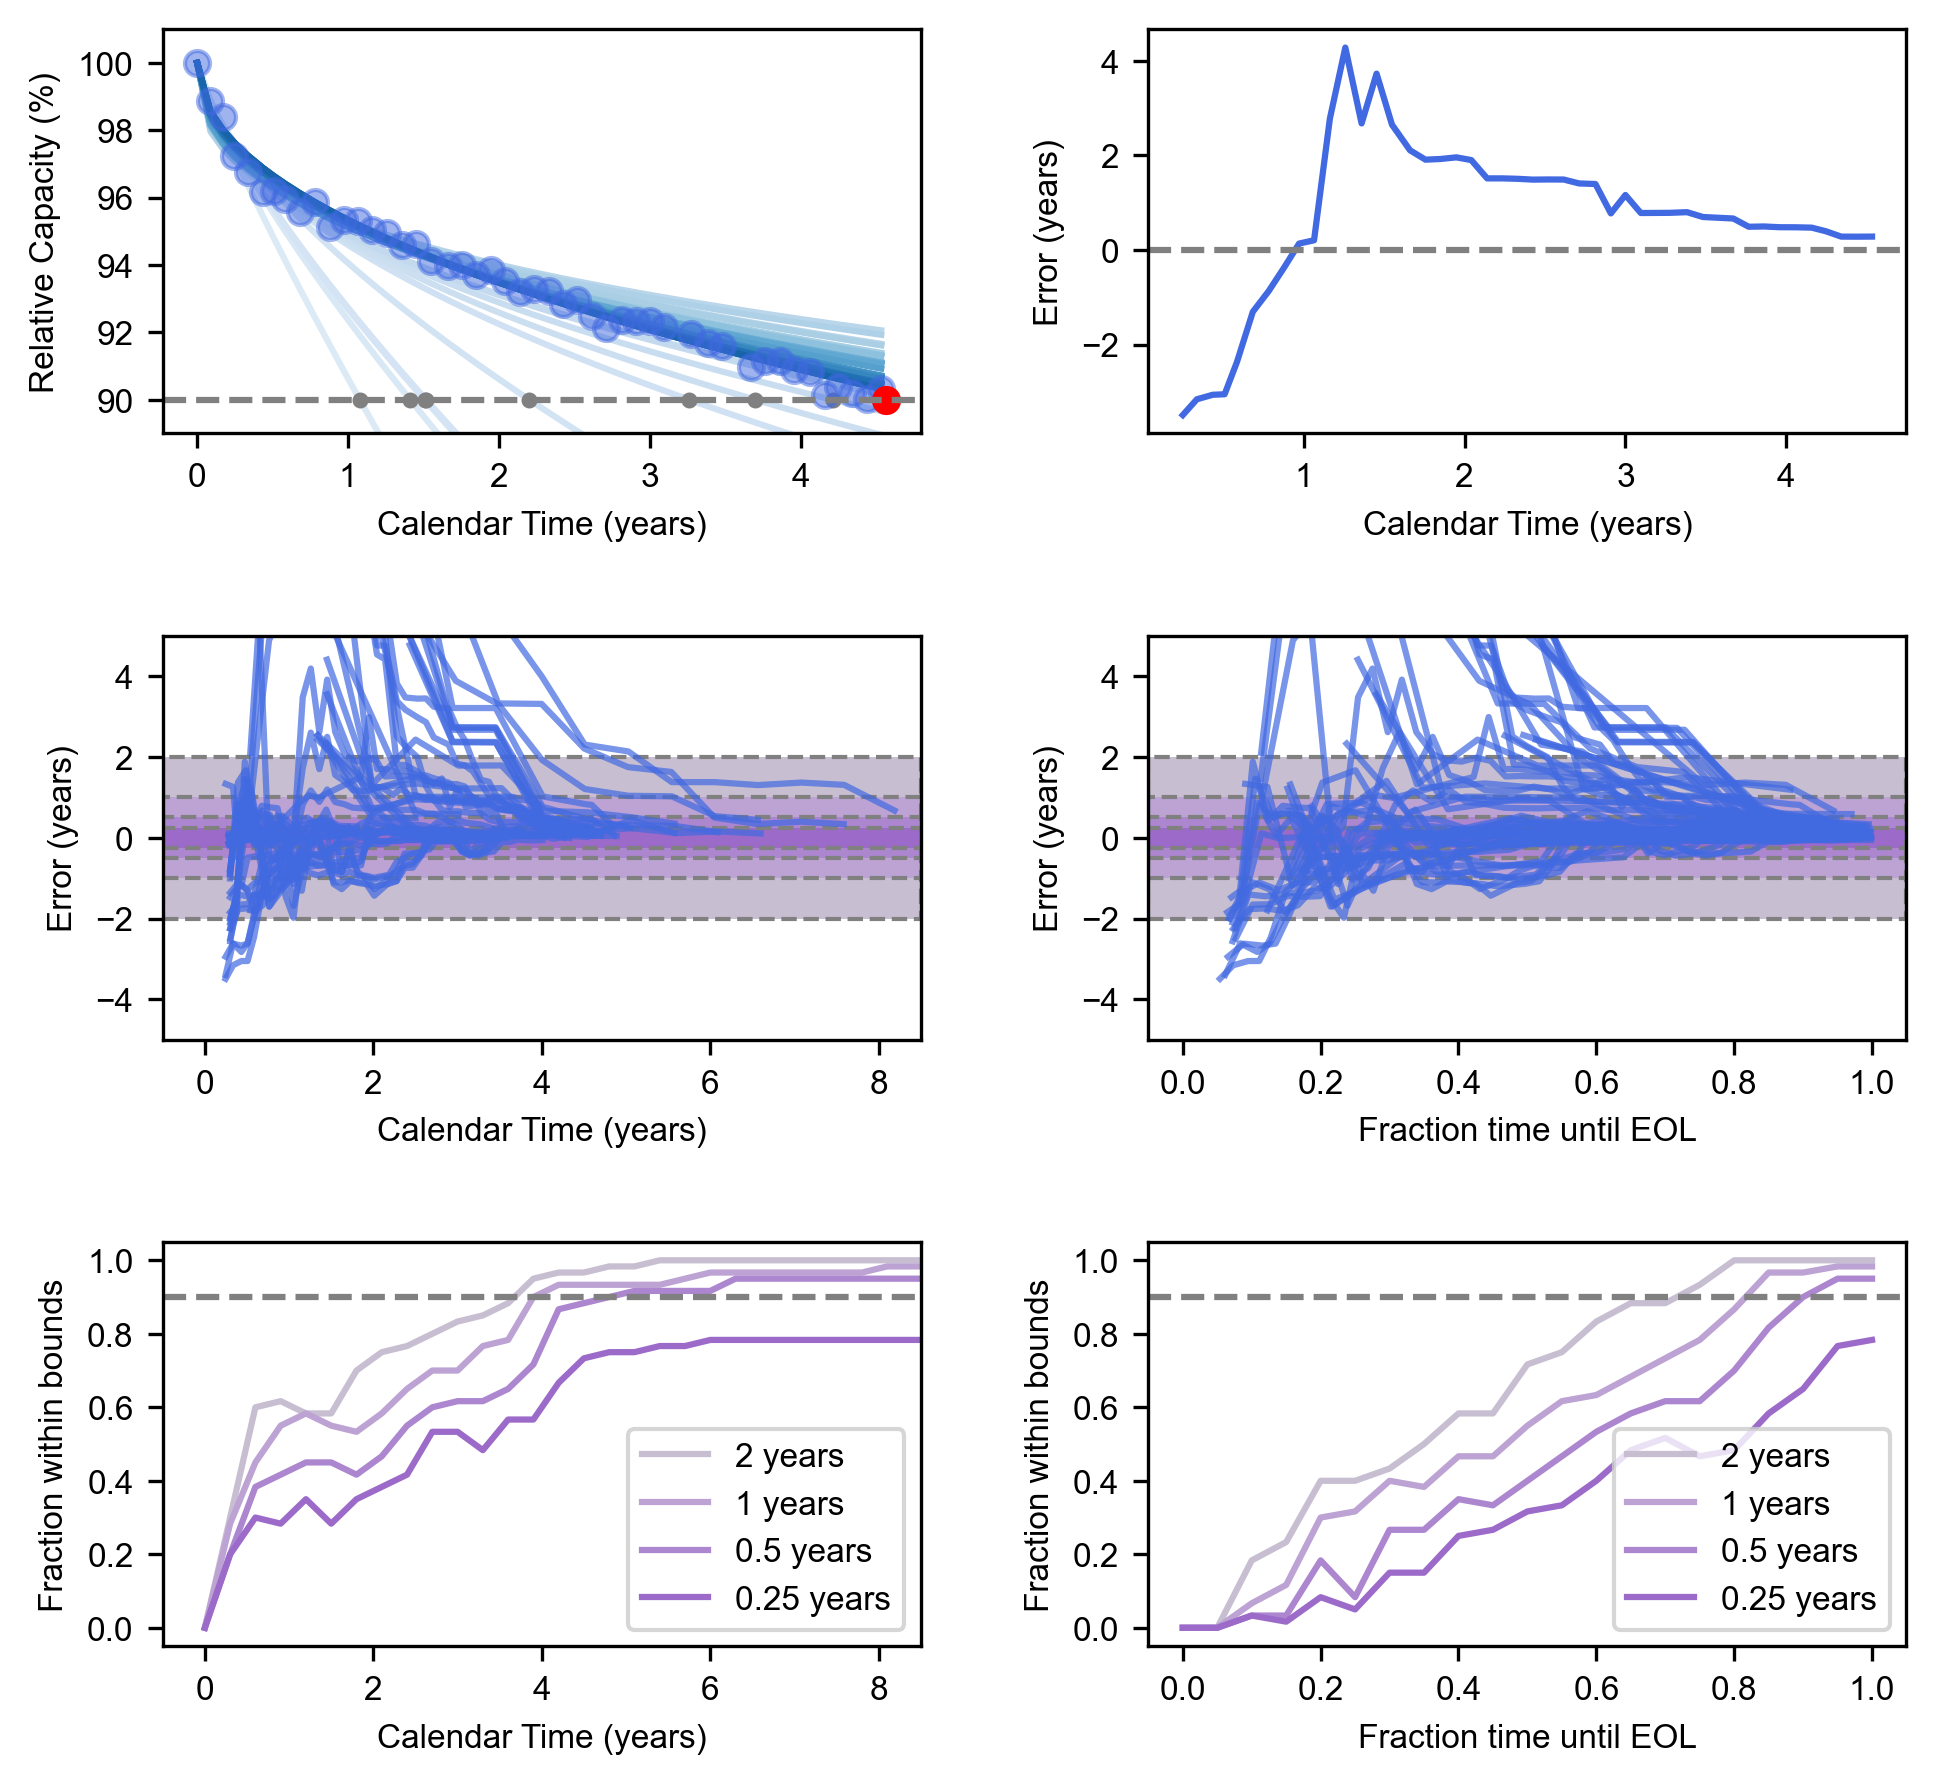

In [50]:
#Plotting stuff all together 

fig, axs = plt.subplots(3,2, figsize=(7.5, 7), dpi=300)


####### Plotting example cell

WEEKS_TO_YEARS = 52.1429
EOL_CAP = 90

#Choose example cell id to plot
cell_id = 'C00085'
sum_name = "{}_sum.json".format(cell_id)
sum_obj=load_sum_obj(file_path=sum_path+sum_name)
df = sum_obj.summary_data
time_points = np.array(df["Calendar_DateTime(days)"])/7
cap_points = df["RPT0.2C_2_D_capacity"]

#first get eol time from smoothed values
_, eol_time = get_smoothed_cap_eol_time(time_points, cap_points, EOL_CAP)
#Use non-smoothed data though
normalized_cap_point = (cap_points/cap_points[0])*100

#only use time points before eol
time_points_before_eol = time_points[time_points<eol_time]
cap_point_until_eol = normalized_cap_point[time_points<eol_time]
eol_error_array = np.ones(len(time_points_before_eol))*np.nan

### Prepare color map. Actual color map is plotted in next cell due to difficulty of inclusion in figure
# Normalize the time points to range [0, 1] for colormap mapping
norm = mcolors.Normalize(vmin=np.min(time_points_before_eol), vmax=np.max(time_points_before_eol))
# Use the 'Blues' colormap and modify it
original_cmap = plt.get_cmap('Blues')
#start from truncated cmap 0.1-0.8 otherwise it is too light or dark to see
new_colors = original_cmap(np.linspace(0.1, 0.8, 256))
custom_cmap = mcolors.ListedColormap(new_colors)
# Now colors are mapped to the values of the time
colors = custom_cmap(norm(time_points_before_eol))

#The minimum datapoints before extrapolation
min_data_points = 4

#perform fitting on the example
ax = axs[0,0]
for time_idx in range(len(time_points_before_eol[:])):
    time_points_truncated = time_points_before_eol[:time_idx+1]
    normalized_cap_point_truncated = normalized_cap_point[:time_idx+1]

    #too few data points
    if len(time_points_truncated)<min_data_points:
        eol_error_array[time_idx] = np.nan
        continue

    # Perform tx fitting
    bounds = [(0, 1000), (0, 10)]
    # Perform differential evolution optimization
    result = differential_evolution(cap_objective_t_x, bounds, args=(time_points_truncated, normalized_cap_point_truncated), maxiter=10000)
    a,b = result.x

    ax.plot(time_points_before_eol/WEEKS_TO_YEARS, cap_t_x_function(time_points_before_eol, a, b), 
                color=colors[time_idx], zorder=1)

    pred_eol_time = get_tx_extrapolated_eol_time(a, b, EOL_CAP)
    eol_error_array[time_idx] = pred_eol_time-eol_time

    #If the predicted eol time is below eol time plot gray dots for example points 
    #that cross the 90% line. 
    if pred_eol_time < eol_time:
        ax.scatter([pred_eol_time/WEEKS_TO_YEARS], [90], color="gray", s=8, zorder=2)



#Plot all raw data itself as well as a red point at where the smoothed capacity EOL point is
ax.scatter(time_points_before_eol/WEEKS_TO_YEARS, cap_point_until_eol, color=color_24C, zorder=2, alpha=0.5)
ax.scatter([eol_time/WEEKS_TO_YEARS],[EOL_CAP], color="red", zorder=2)

ax.set_ylabel("Relative Capacity (%)")
ax.set_xlabel("Calendar Time (years)")
ax.set_ylim([89, 101])

ax.axhline(90, linestyle="--", color="gray")

#Plot how the error trajectory looks like across time
ax = axs[0,1]
ax.plot(np.array(time_points_before_eol)/WEEKS_TO_YEARS, eol_error_array/WEEKS_TO_YEARS, color=color_24C)
ax.axhline(0, color="gray", linestyle = "--")
ax.set_ylabel("Error (years)")
ax.set_xlabel("Calendar Time (years)")



#### Plotting the error trajectory for all cells now
frac_eol_time_lims = [-0.05, 1.05]
real_time_lims = [-0.5, 8.5]

edgecolor = "gray"
linestyle = "--"
##### Plot error trajectory vs real time for all error curves
ax = axs[1,0]
#This plots the error bounds in purple
ax.axhspan(-2, 2, facecolor=purples_hex[0],edgecolor=edgecolor, linestyle=linestyle)
ax.axhspan(-1, 1, facecolor=purples_hex[1],edgecolor=edgecolor, linestyle=linestyle)
ax.axhspan(-0.5, 0.5, facecolor=purples_hex[2], edgecolor=edgecolor, linestyle=linestyle)
ax.axhspan(-0.25, 0.25, facecolor=purples_hex[3], edgecolor=edgecolor, linestyle=linestyle)
for key in eol_error_save_dict.keys():
    time_cutoff_array = eol_error_save_dict[key]["cutoff_year_array"]
    eol_error_array = eol_error_save_dict[key]["eol_error_array"]

    #get color
    cell_type = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==key]["Cell_type"].iloc[0]
    #color = cb_list[cell_type_list.index(cell_type)]
    color = "royalblue"
    
    
    if(np.nanmax(eol_error_array) > 10):
        print(key)
    ax.plot(time_cutoff_array, eol_error_array, color=color, alpha=0.7)

ax.set_ylabel("Error (years)")
ax.set_xlabel("Calendar Time (years)")
ax.set_xlim(real_time_lims)
ax.set_ylim([-5, 5])

#### Plot error trajectory vs fraction until eol for all error curves
ax = axs[1,1]
#shade in error bounds
ax.axhspan(-2, 2, facecolor=purples_hex[0],edgecolor=edgecolor, linestyle=linestyle)
ax.axhspan(-1, 1, facecolor=purples_hex[1],edgecolor=edgecolor, linestyle=linestyle)
ax.axhspan(-0.5, 0.5, facecolor=purples_hex[2], edgecolor=edgecolor, linestyle=linestyle)
ax.axhspan(-0.25, 0.25, facecolor=purples_hex[3], edgecolor=edgecolor, linestyle=linestyle)

for key in eol_error_save_dict.keys():
    time_cutoff_array = eol_error_save_dict[key]["cutoff_year_array"]
    eol_error_array = eol_error_save_dict[key]["eol_error_array"]
    eol_time = eol_error_save_dict[key]["eol_time"]
    color="royalblue"

    #print cellids that have very large errors to look in to if desired
    if(np.nanmax(eol_error_array) > 10):
        print(key)
    
    ax.plot(time_cutoff_array/eol_time, eol_error_array, color=color, alpha=0.7)

ax.set_ylabel("Error (years)")
ax.set_xlabel("Fraction time until EOL")
ax.set_xlim(frac_eol_time_lims)
ax.set_ylim([-5, 5])


#Plot the fraction within the bounds for real time
ax = axs[2,0]
error_bound_array = [2, 1, 0.5, 0.25]
time_sample_array = list(np.arange(0, 9, 0.3))

alpha_array = [1, 0.8, 0.6, 0.4]
for error_bound_idx, error_bound in enumerate(error_bound_array):

    fraction_within_bound = np.zeros(len(time_sample_array))

    for time_idx, time in enumerate(time_sample_array):
        number_within = 0
        total_number = 0

        for cell_id in eol_error_function_dict.keys():
            error = eol_error_function_dict[cell_id](time)

            if np.abs(error)<error_bound:
                number_within+=1
            
            total_number+=1
        
        fraction_within_bound[time_idx] = number_within/total_number

    ax.plot(time_sample_array, fraction_within_bound, label=f"{error_bound} years", 
                color=purples_hex[error_bound_idx])

ax.axhline(0.9, linestyle="--", color="gray")
ax.set_ylabel("Fraction within bounds")
ax.set_xlabel("Calendar Time (years)")
ax.set_xlim(real_time_lims)
ax.legend()


#### Plot fraction within the bounds for fraction eol_time
ax=axs[2,1]
error_bound_array = [2, 1, 0.5, 0.25]
time_sample_array = list(np.arange(0, 1.05, 0.05))

alpha_array = [1, 0.8, 0.6, 0.4]
for error_bound_idx, error_bound in enumerate(error_bound_array):

    fraction_within_bound = np.zeros(len(time_sample_array))

    for time_idx, time in enumerate(time_sample_array):
        number_within = 0
        total_number = 0

        for cell_id in eol_error_function_dict_frac_eol.keys():
            error = eol_error_function_dict_frac_eol[cell_id](time)

            if np.abs(error)<error_bound:
                number_within+=1
            
            total_number+=1
        
        fraction_within_bound[time_idx] = number_within/total_number

    ax.plot(time_sample_array, fraction_within_bound, label=f"{error_bound} years", 
            color=purples_hex[error_bound_idx])

ax.axhline(0.9, linestyle="--", color="gray")
ax.set_ylabel("Fraction within bounds")
ax.set_xlabel("Fraction time until EOL")
ax.set_xlim(frac_eol_time_lims)
ax.legend(loc="lower right")

plt.subplots_adjust(hspace=0.5, wspace=0.3)

#save fig
# fig.savefig("../figures/figure8_tx_eol_extrapolation.svg", transparent=True, format="svg", bbox_inches='tight')

plt.show()


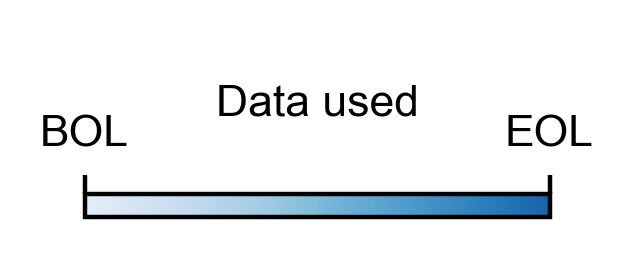

In [51]:
#Get colorbar for the example case. This should match the exact code used for example cell in above cell

fig,axs = plt.subplots(1,1,figsize=(1.5,1), dpi=400)

ax_colorbar = axs

# Normalize the time points to range [0, 1] for colormap mapping
norm = mcolors.Normalize(vmin=np.min(time_points_before_eol), vmax=np.max(time_points_before_eol))
# Use the 'Blues' colormap and modify it
original_cmap = plt.get_cmap('Blues')
#start from truncated cmap since otherwise it is too light or dark to see
new_colors = original_cmap(np.linspace(0.1, 0.8, 256))
custom_cmap = mcolors.ListedColormap(new_colors)
# Now colors are mapped to the values of the time
colors = custom_cmap(norm(time_points_before_eol))

# Add the colorbar at the top
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)

cbar = plt.colorbar(sm,ax=ax_colorbar, orientation='horizontal', fraction=0.5)
cbar.set_ticks([np.min(time_points_before_eol), np.max(time_points_before_eol)])  # Set ticks at min and max
cbar.set_ticklabels(['BOL', 'EOL'])  # Label ticks as 'BOL' and 'EOL'
cbar.set_label("Data used", labelpad=0)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top') 

ax_colorbar.spines['top'].set_visible(False)
ax_colorbar.spines['bottom'].set_visible(False)
ax_colorbar.spines['left'].set_visible(False)
ax_colorbar.spines['right'].set_visible(False)
ax_colorbar.set_xticks([])
ax_colorbar.set_yticks([])

#save colorbar
# fig.savefig("../figures/tx_extrapolation_colorbar.svg", transparent=True, format="svg", bbox_inches='tight')



## SI Figure

In [55]:
# cell_type_list = ['K2 Energy LFP18650E', 'K2 Energy LFP18650P', 'Panasonic NCR18650B',
#                 'Panasonic NCR18650GA', 'Sony-Murata US18650VTC6', 'Tenergy 302030',
#                 'Ultralife 502030', 'Ultralife UBP001']

# cb_list = ['#377eb8', '#ff7f00', '#4daf4a',
#             '#f781bf', '#a65628', '#984ea3',
#             '#999999', '#e41a1c', '#dede00']


cell_type_color_dict = {'K2 Energy LFP18650E': '#377eb8', 'K2 Energy LFP18650P': '#ff7f00',
                        'Panasonic NCR18650B': '#4daf4a', 'Panasonic NCR18650GA': '#f781bf','Sony-Murata US18650VTC6': '#a65628',
                        'Tenergy 302030': '#984ea3', 'Ultralife 502030': '#999999', 'Ultralife UBP001': '#e41a1c'}

C00098
C00208
C00214
C00098
C00208
C00214


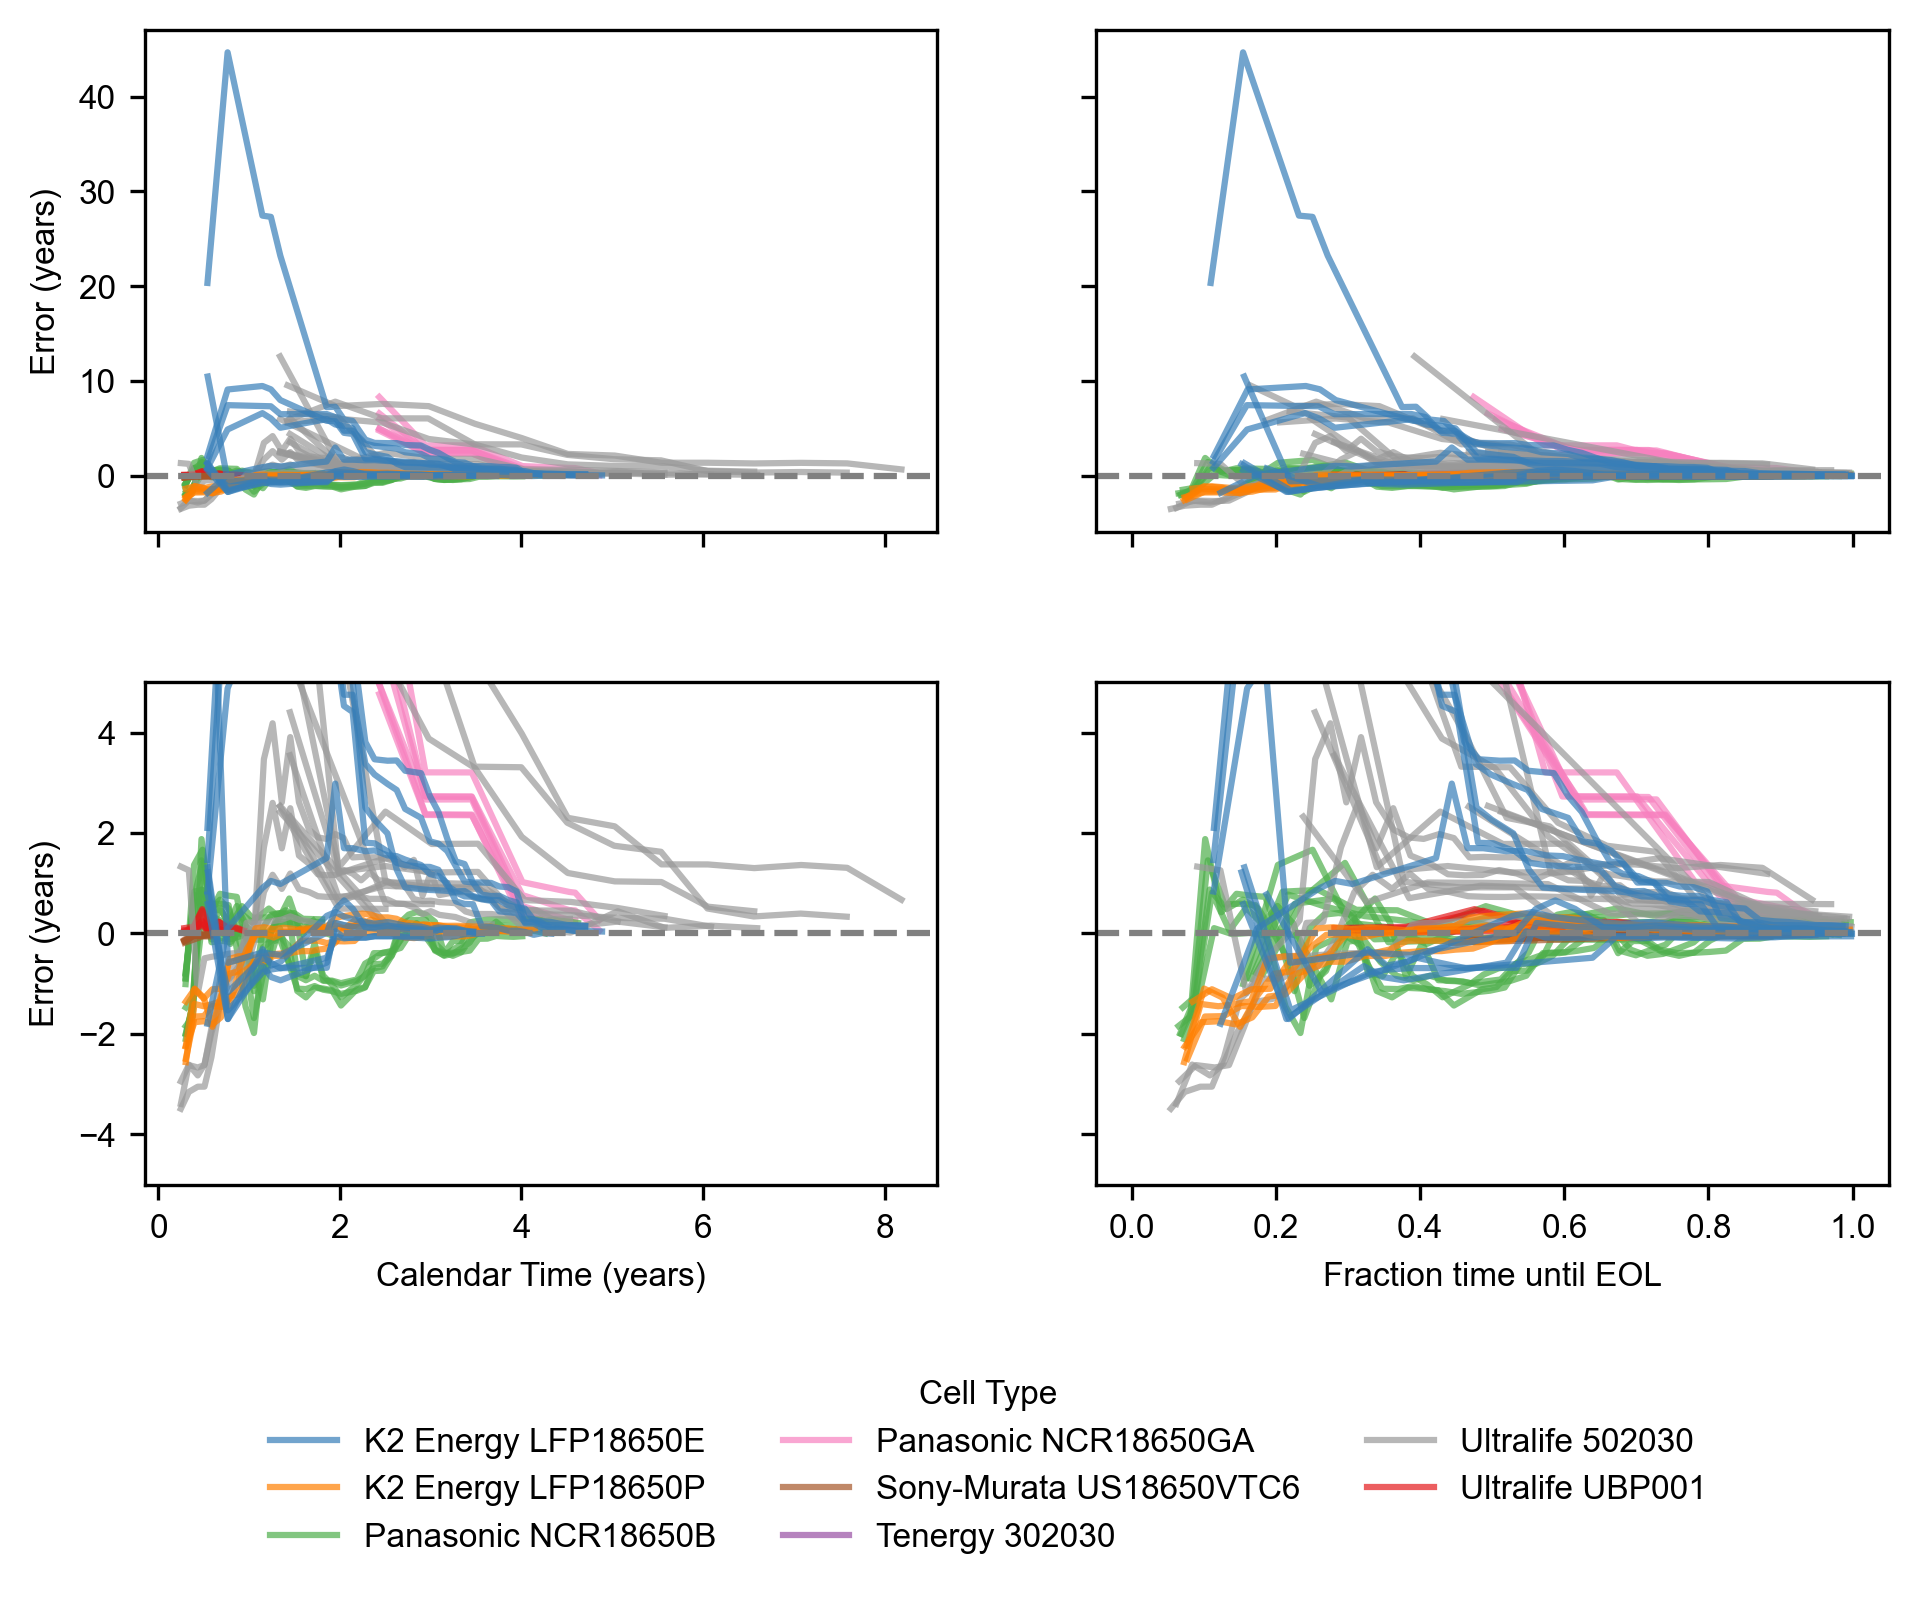

In [58]:
# This figure plots all the error trajectories, but color-coded by cell type to distinguish them
# note that SOC is not distinguished in this plot. 

fig, axs = plt.subplots(2, 2, figsize=(7.5, 5), dpi=300, sharey="row", sharex="col")


ax = axs[0,0]
for key in eol_error_save_dict.keys():
    time_cutoff_array = eol_error_save_dict[key]["cutoff_year_array"]
    eol_error_array = eol_error_save_dict[key]["eol_error_array"]

    #get color
    cell_type = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==key]["Cell_type"].iloc[0]
    color = cell_type_color_dict[cell_type]
    
    if(np.nanmax(eol_error_array) > 10):
        print(key)
    ax.plot(time_cutoff_array, eol_error_array, color=color, alpha=0.7)

ax.set_ylabel("Error (years)")
ax.axhline(0, color="gray", linestyle = "--")


ax = axs[0,1]
for key in eol_error_save_dict.keys():
    time_cutoff_array = eol_error_save_dict[key]["cutoff_year_array"]
    eol_error_array = eol_error_save_dict[key]["eol_error_array"]
    eol_time = eol_error_save_dict[key]["eol_time"]

    #get color
    cell_type = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==key]["Cell_type"].iloc[0]
    color = cell_type_color_dict[cell_type]
    
    ax.plot(time_cutoff_array/eol_time, eol_error_array, color=color, alpha=0.7)
ax.axhline(0, color="gray", linestyle = "--")


#### same plots as above just truncated on y-axis now
ax = axs[1,0]
for key in eol_error_save_dict.keys():
    time_cutoff_array = eol_error_save_dict[key]["cutoff_year_array"]
    eol_error_array = eol_error_save_dict[key]["eol_error_array"]

    #get color
    cell_type = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==key]["Cell_type"].iloc[0]
    color = cell_type_color_dict[cell_type]
    
    
    if(np.nanmax(eol_error_array) > 10):
        print(key)
    ax.plot(time_cutoff_array, eol_error_array, color=color, alpha=0.7)

ax.set_ylim([-5, 5])
ax.set_ylabel("Error (years)")
ax.set_xlabel("Calendar Time (years)")
ax.axhline(0, color="gray", linestyle = "--")


ax = axs[1,1]
for key in eol_error_save_dict.keys():
    time_cutoff_array = eol_error_save_dict[key]["cutoff_year_array"]
    eol_error_array = eol_error_save_dict[key]["eol_error_array"]
    eol_time = eol_error_save_dict[key]["eol_time"]

    #get color
    cell_type = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==key]["Cell_type"].iloc[0]
    color = cell_type_color_dict[cell_type]
    
    ax.plot(time_cutoff_array/eol_time, eol_error_array, color=color, alpha=0.7)

ax.set_xlabel("Fraction time until EOL")
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-5, 5])
ax.axhline(0, color="gray", linestyle = "--")

plt.subplots_adjust(hspace=0.3, wspace=0.2)

## adding the legend
line_legend_list = []
for idx, cell_type in enumerate(cell_type_list):
    line_cell_type = Line2D([0], [0], label=cell_type, color=cell_type_color_dict[cell_type], alpha=0.7)
    line_legend_list.append(line_cell_type)


fig.legend(handles=line_legend_list, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3, title="Cell Type", frameon=False)

# Save figure
# fig.savefig("../figures/SI_figure_tx_extrapolation_celltype_zoom.svg", transparent=True, format="svg", bbox_inches='tight')

plt.show()

